In [1]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/naomiverkerk/TM10007.git


## Import data

In [22]:
## Import
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn import svm
from sklearn import decomposition
import statistics

# Preprocessing
from load_data import load_data
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler, LabelEncoder

# Classifiers and kernels
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

#
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer, make_column_selector as selector


## Loading Data

In [85]:
##Loading Data
data = load_data()
X = data
X = X.replace(np.inf, np.nan)
Y = data['label']
del X['label']

# Duplicate check

In [70]:
# Check for duplicates values
data.drop_duplicates(keep='first')
print(f'Number of duplicated datasets = {data.duplicated().sum()}')

# Check for duplicates columns
data.columns.drop_duplicates(keep='first')
print(f'Number of duplicated features = {data.columns.duplicated().sum()}')

Number of duplicated datasets = 0
Number of duplicated features = 0


# Label counter

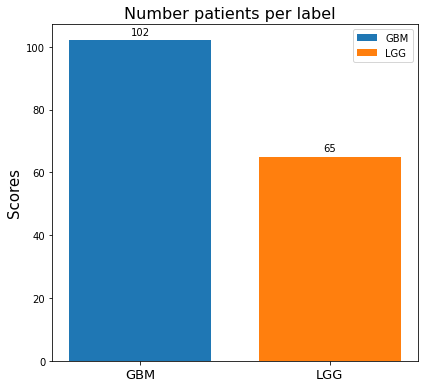

In [25]:
label_count = Y.value_counts()
z = np.arange(len(label_count.index))
width = 0.75
fig, ax = plt.subplots(figsize = (6,5.5))
count1 = ax.bar(0.5, label_count.values[0], width, label=label_count.index[0])
count2 = ax.bar(1.5, label_count.values[1], width, label=label_count.index[1])

ax.set_ylabel('Scores', fontsize = 15)
ax.set_title('Number patients per label  ', fontsize = 16)
ax.set_xticks([0.5,1.5], list(label_count.index), fontsize = 13)
ax.legend()
ax.bar_label(count1, padding=3)
ax.bar_label(count2, padding=3)
ax.grid(False)
fig.tight_layout()

plt.show()

## Splitting into test and train(design)

In [86]:
## Split
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size = 0.2, random_state = 4, stratify = Y)

In [57]:
import matplotlib.patches as mpatches
def scatterplot_distribution(Y,Y1,Y2,data,X1,X2):

    encoder = LabelEncoder()
    Y = encoder.fit_transform(Y)   
    
    colour = sns.color_palette("Set2")
    color1=colour[0]
    color2=colour[1]
    colormap = np.array([color1,color2])

    fig = plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(131)
    ax1.set_title(f"Brats, entire dataset = {len(data)}", fontsize=15)
    ax1.scatter(data.iloc[:,0], data.iloc[:,1], marker='o', c=colormap[Y],
            s=45, edgecolor='k', cmap=plt.cm.Paired)

    # ax2 = fig.add_subplot(132, sharex = ax1, sharey = ax1)
    ax2 = fig.add_subplot(132)
    ax2.set_title("X1", fontsize=15)
    ax2.scatter(X1.iloc[:,0], X1.iloc[:,1], marker='o', c=colormap[Y1],
            s=45, edgecolor='k', cmap=plt.cm.Paired)

    # ax3 = fig.add_subplot(133, sharex = ax1, sharey = ax1)
    ax3 = fig.add_subplot(133)
    ax3.set_title("X2", fontsize=15)
    ax3.scatter(X2.iloc[:,0], X2.iloc[:,1], marker='o', c=colormap[Y2],
            s=45, edgecolor='k', cmap=plt.cm.Paired)   

    GBM_patch = mpatches.Patch(color=colour[0], label='GBM')
    LGG_patch = mpatches.Patch(color=colour[1], label='LGG')
    fig.legend(handles=[GBM_patch, LGG_patch],loc="center right", prop={'size': 12})
    fig.subplots_adjust(right=0.95)

    plt.show()

## Plaatjes, weg?

In [7]:
## Nog ff naar kijken of het werkt
# from fitter import Fitter, get_common_distributions, get_distributions
# fi = []

# col = X.columns
# for i in (range(0,X.shape[1],1)):
#     try:
#         X_tr = X[col[i]].values
#         f = Fitter(X_tr,
#             distributions=['gamma',
#                             'lognorm',
#                             "beta",
#                             "burr",
#                             "norm"])
#         f.fit()
#         fi.append(list(pd.DataFrame(f.get_best(method = 'sumsquare_error')).columns))
#     except Exception:
#         pass

# flat_list = [item for sublist in fi for item in sublist]
# from collections import Counter
# Counter(flat_list).most_common()       
# from sklearn import preprocessing
# import seaborn as sns
# import matplotlib.patches as mpatches
# import matplotlib.pyplot as plt

# le = preprocessing.LabelEncoder()

# y_10 = le.fit_transform(Y)
# Y_train_10 = le.fit_transform(Y_train)
# Y_test_10 = le.fit_transform(Y_test)
# # classes = data.label
# # classes = list(classes.unique())
# colour = sns.color_palette("Set2")
# color1=colour[0]
# color2=colour[1]

# colormap = np.array([color1,color2])

# fig = plt.figure(figsize=(24,8))
# ax = fig.add_subplot(131)
# ax.set_title(f"Brats, entire dataset = {len(data)}", fontsize=15)
# ax.scatter(data.iloc[:,0], data.iloc[:,1], marker='o', c=colormap[y_10],
#            s=45, edgecolor='k', cmap=plt.cm.Paired)

# ax = fig.add_subplot(132)
# ax.set_title(f"Training data = {len(X_train)}", fontsize=15)
# ax.scatter(X_train.iloc[:,0], X_train.iloc[:,1], marker='o', c=colormap[Y_train_10],
#            s=45, edgecolor='k', cmap=plt.cm.Paired)

# ax = fig.add_subplot(133)
# ax.set_title(f"Test data= {len(X_test)}", fontsize=15)
# ax.scatter(X_test.iloc[:,0], X_test.iloc[:,1], marker='o', c=colormap[Y_test_10],
#            s=45, edgecolor='k', cmap=plt.cm.Paired)   

# GBM_patch = mpatches.Patch(color=colour[0], label='GBM')
# LGG_patch = mpatches.Patch(color=colour[1], label='LGG')
# fig.legend(handles=[GBM_patch, LGG_patch],loc="center right", prop={'size': 12})
# fig.subplots_adjust(right=0.95)

# plt.show()          

## Features removal

In [87]:
## Features weghalen met teveel missing values
acceptabele_ratio = 0.5
train_size = len(X_train.index)
removal_rate = round(train_size*acceptabele_ratio)

X_train = X_train.dropna(axis=1, thresh=removal_rate)


test_size = len(X_test.index)
removal_rate = round(test_size*acceptabele_ratio)
X_test = X_test.dropna(axis=1, thresh=removal_rate)
print(X_train.shape)
print(X_test.shape)


(133, 704)
(34, 704)


## Imputation with KNN

In [89]:
imputer = KNNImputer()
imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

# np.isnan(X_train_imputer).sum()
# np.isnan(X_test_imputer).sum()

## Scaling

In [90]:
## Scaling
scaler = RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


## Label encoder for scaling Y

In [91]:
## scaling van y
scaler = LabelEncoder()
scaler.fit(Y_train)
Y_train = scaler.transform(Y_train)
Y_test = scaler.transform(Y_test)

## PCA

In [93]:
## PCA
pca = decomposition.PCA(n_components=0.99, svd_solver= 'full')
pca.fit(X_train)
X_train_final = pca.transform(X_train)
X_test_final = pca.transform(X_test)
explained_variance = np.cumsum(pca.explained_variance_ratio_)
print(explained_variance)


[0.94938451 0.9824626  0.98936905 0.99161961]


## Parameters

In [96]:
cv_10fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
cv_5fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

clf_list = [KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression(), RandomForestClassifier(), SVC(probability=True)]

parameters_list = [
        {
                "n_neighbors": range(1,20,1),
                "weights": ["uniform", "distance"],
        },
        {
                "criterion": ['gini', 'entropy'],
                "min_samples_split": list(range(2,40,2)),
                "max_features": [1,2,3,4],
                "min_samples_leaf": list(range(1,20,2)),
        },
        {
                'solver': ['newton-cg', 'lbfgs', 'liblinear'],
                'penalty' :["l1", 'l2', 'elasticnet', 'none'],
                'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        },
        {
                "n_estimators" : range(20,100,5),
                "criterion": ['gini', 'entropy'],
                "min_samples_split": list(range(2,40,2)),
                "max_features": [1,2,3,4],
                "min_samples_leaf": list(range(1,20,2)),
        },
        {
                'degree': [1, 3, 5],
                'coef0': [0.01, 0.5, 1],
                'C': [0.01, 0.5, 1],
                'kernel': ['poly', 'rbf', 'sigmoid']
        },
]


# KNN

1.0
1.0
0.7647058823529411
0.7583333333333333
0.7166666666666667
0.7416666666666667
1.0
0.7666666666666667
0.7583333333333333
0.7583333333333333
The optimal n_neighbors=14
The optimal weights=uniform


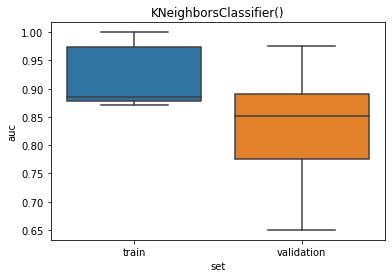

In [108]:
results = []
for train_index, validation_index, in cv_10fold.split(X_train, Y_train):
    
    X_train_CV = X_train[train_index]
    Y_train_CV = Y_train[train_index]

    X_validation_CV = X_train[validation_index]
    Y_validation_CV = Y_train[validation_index]
    
    clf = clf_list[0]
    parameters = parameters_list[0]
    randomized_search = RandomizedSearchCV(clf, parameters, cv=cv_5fold, scoring='roc_auc', n_iter = 10)
    randomized_search.fit(X_train_CV, Y_train_CV)
    
    # Get resulting classifier
    clf = randomized_search.best_estimator_

    # Test the classifier on the train data
    probabilities = clf.predict_proba(X_train_CV)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(Y_train_CV, scores)
    results.append({
        'auc': auc,
        'n_neighbors': clf.n_neighbors,
        "weights": clf.weights,
        "metric": clf.metric,
        'set': 'train'
    })
    
    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation_CV)
    scores_validation = probabilities_validation[:, 1]
    print(clf.score(X_train_CV, Y_train_CV))
    # Get the auc
    auc_validation = metrics.roc_auc_score(Y_validation_CV, scores_validation)
    results.append({
        'auc': auc_validation,
        'n_neighbors': clf.n_neighbors,
        "weights": clf.weights,
        "metric": clf.metric,
        'set': 'validation'
    })
    
#Create results dataframe and plot it
results = pd.DataFrame(results)
sns.boxplot(y='auc', x='set', data=results).set_title(f'{clf_list[0]}')

optimal_parameter = []
parameter_keys = list(parameters.keys())

for item in parameter_keys:
    best_item = [] 
    for i in list(range(0,10,2)):
        best_item.append(results[item][i])
    
    optimal_parameter.append(statistics.median(best_item))
    print(f"The optimal {item}={optimal_parameter[-1]}")



In [111]:
clf = clf_list[0]
parameters = parameters_list[0]
randomized_search = RandomizedSearchCV(clf, parameters, cv=cv_5fold, scoring='roc_auc', n_iter = 10)
randomized_search.fit(X_train_final, Y_train)
    
# Get resulting classifier
clf = randomized_search.best_estimator_

# Test the classifier on the train data

print(clf.score(X_train_final, Y_train))

print(clf.score(X_test_final, Y_test))

1.0
0.7647058823529411


# Decision tree

The optimal criterion=gini
The optimal min_samples_split=20
The optimal max_features=3
The optimal min_samples_leaf=9


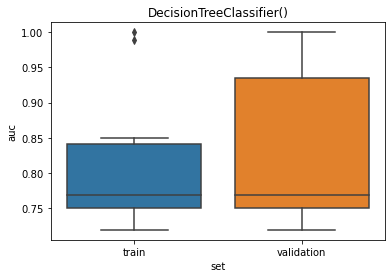

In [15]:
results = []
for train_index, validation_index, in cv_10fold.split(X_train, Y_train):
    
    X_train_CV = X_train[train_index]
    Y_train_CV = Y_train[train_index]

    X_validation_CV = X_train[validation_index]
    Y_validation_CV = Y_train[validation_index]
    
    clf = clf_list[1]
    parameters = parameters_list[1]
    randomized_search = RandomizedSearchCV(clf, parameters, cv=cv_5fold, scoring='roc_auc', n_iter = 10)
    randomized_search.fit(X_train_CV, Y_train_CV)
    
    # Get resulting classifier
    clf = randomized_search.best_estimator_

    # Test the classifier on the train data
    probabilities = clf.predict_proba(X_train_CV)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(Y_train_CV, scores)
    results.append({
        'auc': auc_validation,
        'criterion': clf.criterion,
        'min_samples_split': clf.min_samples_split,
        'max_features': clf.max_features,
        "min_samples_leaf": clf.min_samples_leaf,
        'set': 'train'
    })
    
    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation_CV)
    scores_validation = probabilities_validation[:, 1]
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(Y_validation_CV, scores_validation)
    results.append({
        'auc': auc_validation,
        'criterion': clf.criterion,
        'min_samples_split': clf.min_samples_split,
        'max_features': clf.max_features,
        "min_samples_leaf": clf.min_samples_leaf,
        'set': 'validation'
    })
    
#Create results dataframe and plot it
results = pd.DataFrame(results)
sns.boxplot(y='auc', x='set', data=results).set_title(f'{clf_list[1]}')

optimal_parameter = []
parameter_keys = list(parameters.keys())

for item in parameter_keys:
    best_item = [] 
    for i in list(range(0,10,2)):
        best_item.append(results[item][i])
    
    optimal_parameter.append(statistics.median(best_item))
    print(f"The optimal {item}={optimal_parameter[-1]}")
  

In [113]:
clf = clf_list[1]
parameters = parameters_list[1]
randomized_search = RandomizedSearchCV(clf, parameters, cv=cv_5fold, scoring='roc_auc', n_iter = 10)
randomized_search.fit(X_train_final, Y_train)
    
# Get resulting classifier
clf = randomized_search.best_estimator_

# Test the classifier on the train data

print(clf.score(X_train_final, Y_train))

print(clf.score(X_test_final, Y_test))

0.8345864661654135
0.7058823529411765


# Logistic Regression

C:\Users\Sara\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Sara\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Sara\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Sara\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Sara\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Sara\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
40 f

Text(0.5, 1.0, 'LogisticRegression()')

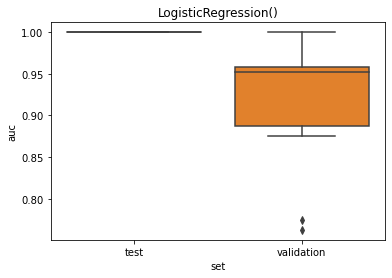

In [16]:
results = []
for train_index, validation_index, in cv_10fold.split(X_train, Y_train):
    
    X_train_CV = X_train[train_index]
    Y_train_CV = Y_train[train_index]

    X_validation_CV = X_train[validation_index]
    Y_validation_CV = Y_train[validation_index]
    
    clf = clf_list[2]
    parameters = parameters_list[2]
    randomized_search = RandomizedSearchCV(clf, parameters, cv=cv_5fold, scoring='roc_auc', n_iter = 10)
    randomized_search.fit(X_train_CV, Y_train_CV)
    
    # Get resulting classifier
    clf = randomized_search.best_estimator_

    # Test the classifier on the train data
    probabilities = clf.predict_proba(X_train_CV)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(Y_train_CV, scores)
    results.append({
        'auc': auc,
        'solver' : clf.solver,
        'penalty' : clf.penalty,
        'C' : clf.C,
        'set': 'test',
    })
    
    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation_CV)
    scores_validation = probabilities_validation[:, 1]
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(Y_validation_CV, scores_validation)
    results.append({
        'auc': auc_validation,
        'solver' : clf.solver,
        'C' : clf.C,
        'penalty' : clf.penalty,
        'set': 'validation'
    })
    
#Create results dataframe and plot it
results = pd.DataFrame(results)
sns.boxplot(y='auc', x='set', data=results).set_title(f'{clf_list[2]}')

# optimal_parameter = []
# parameter_keys = list(parameters.keys())

# for item in parameter_keys:
#     best_item = [] 
#     for i in list(range(0,10,2)):
#         best_item.append(results[item][i])
    
#     optimal_parameter.append(statistics.median(best_item))
#     print(f"The optimal {item}={optimal_parameter[-1]}")

In [114]:
import warnings
warnings.filterwarnings("ignore")
clf = clf_list[2]
parameters = parameters_list[2]
randomized_search = RandomizedSearchCV(clf, parameters, cv=cv_5fold, scoring='roc_auc', n_iter = 10)
randomized_search.fit(X_train_final, Y_train)
    
# Get resulting classifier
clf = randomized_search.best_estimator_

# Test the classifier on the train data

print(clf.score(X_train_final, Y_train))

print(clf.score(X_test_final, Y_test))

0.849624060150376
0.7058823529411765


# Random Forest

The optimal n_estimators=60
The optimal criterion=gini
The optimal min_samples_split=14
The optimal max_features=3
The optimal min_samples_leaf=9


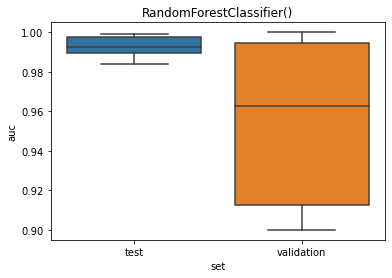

In [17]:
results = []
for train_index, validation_index, in cv_10fold.split(X_train, Y_train):
    
    X_train_CV = X_train[train_index]
    Y_train_CV = Y_train[train_index]

    X_validation_CV = X_train[validation_index]
    Y_validation_CV = Y_train[validation_index]
    
    clf = clf_list[3]
    parameters = parameters_list[3]
    randomized_search = RandomizedSearchCV(clf, parameters, cv=cv_5fold, scoring='roc_auc', n_iter = 10)
    randomized_search.fit(X_train_CV, Y_train_CV)
    
    # Get resulting classifier
    clf = randomized_search.best_estimator_

    # Test the classifier on the train data
    probabilities = clf.predict_proba(X_train_CV)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(Y_train_CV, scores)
    results.append({
        'auc': auc,
        "criterion": clf.criterion,
        "min_samples_split": clf.min_samples_split,
        "max_features": clf.max_features,
        "min_samples_leaf": clf.min_samples_leaf,
        "n_estimators" : clf.n_estimators,
        'set': 'test'
    })
    
    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation_CV)
    scores_validation = probabilities_validation[:, 1]
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(Y_validation_CV, scores_validation)
    results.append({
        'auc': auc_validation,
        "criterion": clf.criterion,
        "min_samples_split": clf.min_samples_split,
        "max_features": clf.max_features,
        "min_samples_leaf": clf.min_samples_leaf,
        "n_estimators" : clf.n_estimators,
        'set': 'validation'

    })

    
    
#Create results dataframe and plot it
results = pd.DataFrame(results)
sns.boxplot(y='auc', x='set', data=results).set_title(f'{clf_list[3]}')

optimal_parameter = []
parameter_keys = list(parameters.keys())

for item in parameter_keys:
    best_item = [] 
    for i in list(range(0,10,2)):
        best_item.append(results[item][i])
    
    optimal_parameter.append(statistics.median(best_item))
    print(f"The optimal {item}={optimal_parameter[-1]}")

In [115]:
clf = clf_list[3]
parameters = parameters_list[3]
randomized_search = RandomizedSearchCV(clf, parameters, cv=cv_5fold, scoring='roc_auc', n_iter = 10)
randomized_search.fit(X_train_final, Y_train)
    
# Get resulting classifier
clf = randomized_search.best_estimator_

# Test the classifier on the train data

print(clf.score(X_train_final, Y_train))

print(clf.score(X_test_final, Y_test))

0.7969924812030075
0.7647058823529411


# SVM

Text(0.5, 1.0, 'SVC(probability=True)')

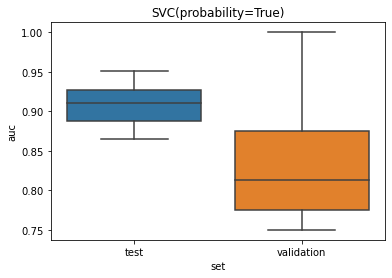

In [18]:
results = []
for train_index, validation_index, in cv_10fold.split(X_train, Y_train):
    
    X_train_CV = X_train[train_index]
    Y_train_CV = Y_train[train_index]

    X_validation_CV = X_train[validation_index]
    Y_validation_CV = Y_train[validation_index]
    
    clf = clf_list[4]
    parameters = parameters_list[4]
    randomized_search = RandomizedSearchCV(clf, parameters, cv=cv_5fold, scoring='roc_auc', n_iter = 10)
    randomized_search.fit(X_train_CV, Y_train_CV)
    
    # Get resulting classifier
    clf = randomized_search.best_estimator_

    # Test the classifier on the train data
    probabilities = clf.predict_proba(X_train_CV)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(Y_train_CV, scores)
    results.append({
        'auc': auc,
        'degree': clf.degree,
        'coef0': clf.coef0,
        'C': clf.C,
        'kernel': clf.kernel,
        'set': 'test'
    })
    
    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation_CV)
    scores_validation = probabilities_validation[:, 1]
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(Y_validation_CV, scores_validation)
    results.append({
        'auc': auc_validation,
        'degree': clf.degree,
        'coef0': clf.coef0,
        'C': clf.C,
        'kernel': clf.kernel,
        'set': 'validation'
    })
    
    # Results of the testset
    results_test =[]

    # Test the classifier on the train data
    probabilities_test = clf.predict_proba(X_test_final)
    scores_test = probabilities_test[:, 1]

    auc_test = metrics.roc_auc_score(Y_test, scores_test)
    accuracy_test = metrics.accuracy_score(Y_test, scores_test)
    results_test.append({
        'auc': auc_test,
        'degree': clf.degree,
        'coef0': clf.coef0,
        'C': clf.C,
        'kernel': clf.kernel,
        'accuracy': accuracy_test,
        'set': 'test'
    })

results_test = pd.DataFrame(results_test)
sns.boxplot(y='auc', x='set', data=results).set_title(f'{clf_list[3]}')
print(results_test)
#Create results dataframe and plot it
results = pd.DataFrame(results)
sns.boxplot(y='auc', x='set', data=results).set_title(f'{clf_list[4]}')




In [116]:
clf = clf_list[4]
parameters = parameters_list[4]
randomized_search = RandomizedSearchCV(clf, parameters, cv=cv_5fold, scoring='roc_auc', n_iter = 10)
randomized_search.fit(X_train_final, Y_train)
    
# Get resulting classifier
clf = randomized_search.best_estimator_

# Test the classifier on the train data

print(clf.score(X_train_final, Y_train))

print(clf.score(X_test_final, Y_test))

0.6090225563909775
0.6176470588235294
